<a href="https://colab.research.google.com/github/racego/AIRE_LAURA_SEMANA_5_ANALISIS/blob/main/aire_calidad_semana5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PASO 1: INSTALACIÓN E IMPORTACIÓN DE LIBRERÍAS

In [1]:
print("PASO 1: INSTALANDO E IMPORTANDO LIBRERÍAS...")

!pip install gspread google-auth > /dev/null 2>&1
!pip install seaborn > /dev/null 2>&1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración para mejores gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Librerías instaladas e importadas correctamente")

PASO 1: INSTALANDO E IMPORTANDO LIBRERÍAS...
Librerías instaladas e importadas correctamente


# PASO 2: CARGA DE DATOS DESDE GOOGLE SHEETS

In [2]:
print("\n PASO 2: CARGANDO DATOS DESDE GOOGLE SHEETS...")

def cargar_datos_desde_sheets():
    try:
        import gspread
        from google.colab import auth
        from google.auth import default

        # Autenticación
        auth.authenticate_user()
        gc = gspread.authorize(default()[0])

        # ID del documento
        sheet_id = "1XQaAwhm42n3-8O5s_M9rYCq2iEkTrivY"

        print(" Accediendo a Google Sheets...")
        sh = gc.open_by_key(sheet_id)
        worksheet = sh.sheet1

        # Obtener todos los datos
        datos = worksheet.get_all_records()
        df = pd.DataFrame(datos)

        print(f" Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
        return df

    except Exception as e:
        print(f" Error: {e}")
        print(" Usando datos de ejemplo...")
        return crear_datos_ejemplo()

def crear_datos_ejemplo():
    """Crear datos de ejemplo realistas para las estaciones de Bogotá"""
    np.random.seed(42)

    # Crear fechas para un año completo
    fechas = pd.date_range('2023-01-01', '2023-12-31', freq='D')
    n_registros = len(fechas)

    # Datos realistas para cada estación basados en patrones típicos de Bogotá
    datos = {
        'Fecha': np.tile(fechas, 4),
        'Estacion': (['Carvajal'] * n_registros +
                    ['Ciudad Bolivar'] * n_registros +
                    ['Fontibon'] * n_registros +
                    ['Kennedy'] * n_registros),
        'PM25': np.concatenate([
            # Carvajal - niveles moderados
            np.random.lognormal(2.1, 0.7, n_registros) + np.random.normal(0, 3, n_registros),
            # Ciudad Bolivar - niveles más altos
            np.random.lognormal(2.4, 0.8, n_registros) + np.random.normal(2, 4, n_registros),
            # Fontibon - niveles moderados-bajos
            np.random.lognormal(1.9, 0.6, n_registros) + np.random.normal(0, 2, n_registros),
            # Kennedy - niveles variables
            np.random.lognormal(2.2, 0.9, n_registros) + np.random.normal(1, 5, n_registros)
        ]),
        'PM10': np.concatenate([
            # Carvajal
            np.random.lognormal(2.5, 0.6, n_registros) + np.random.normal(5, 6, n_registros),
            # Ciudad Bolivar
            np.random.lognormal(2.8, 0.7, n_registros) + np.random.normal(8, 7, n_registros),
            # Fontibon
            np.random.lognormal(2.3, 0.5, n_registros) + np.random.normal(4, 5, n_registros),
            # Kennedy
            np.random.lognormal(2.6, 0.8, n_registros) + np.random.normal(6, 8, n_registros)
        ])
    }

    # Asegurar valores positivos
    datos['PM25'] = np.maximum(datos['PM25'], 0)
    datos['PM10'] = np.maximum(datos['PM10'], 0)

    df = pd.DataFrame(datos)
    print(" Datos de ejemplo creados para análisis")
    return df

# Cargar datos
df = cargar_datos_desde_sheets()


 PASO 2: CARGANDO DATOS DESDE GOOGLE SHEETS...
 Accediendo a Google Sheets...
 Error: APIError: [400]: This operation is not supported for this document
 Usando datos de ejemplo...
 Datos de ejemplo creados para análisis


# PASO 3: EXPLORACIÓN INICIAL Y LIMPIEZA

In [3]:
print("\n PASO 3: EXPLORACIÓN INICIAL DE DATOS...")

print(" Primeras 10 filas del dataset:")
print(df.head(10))

print("\n Información del dataset:")
print(f"• Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"• Columnas: {list(df.columns)}")

print("\n Estadísticas descriptivas básicas:")
print(df.describe())

print("\n Valores faltantes por columna:")
print(df.isnull().sum())

# Limpieza de nombres de columnas
df.columns = [col.strip().replace(' ', '_') for col in df.columns]

# Verificar y estandarizar nombres de estaciones
if 'Estacion' in df.columns:
    estaciones_originales = df['Estacion'].unique()
    print(f"\n Estaciones identificadas: {list(estaciones_originales)}")

    # Estandarizar nombres
    mapeo_estaciones = {
        'carvajal': 'Carvajal', 'CARVAJAL': 'Carvajal',
        'ciudad_bolivar': 'Ciudad Bolivar', 'CIUDAD BOLIVAR': 'Ciudad Bolivar',
        'fontibon': 'Fontibon', 'FONTIBON': 'Fontibon',
        'kennedy': 'Kennedy', 'KENNEDY': 'Kennedy'
    }

    df['Estacion'] = df['Estacion'].str.strip().replace(mapeo_estaciones)

# Verificar contaminantes
contaminantes = ['PM25', 'PM10', 'PM2.5', 'pm25', 'pm10']
pm25_col = next((col for col in contaminantes if col in df.columns), None)
pm10_col = next((col for col in contaminantes if col in df.columns and '10' in col), None)

if pm25_col and pm25_col != 'PM25':
    df['PM25'] = df[pm25_col]
if pm10_col and pm10_col != 'PM10':
    df['PM10'] = df[pm10_col]

print(f"\n Contaminantes a analizar: PM2.5 y PM10")


 PASO 3: EXPLORACIÓN INICIAL DE DATOS...
 Primeras 10 filas del dataset:
       Fecha  Estacion       PM25       PM10
0 2023-01-01  Carvajal  10.358062  21.935051
1 2023-01-02  Carvajal   8.085128  22.068062
2 2023-01-03  Carvajal  12.888268  14.569333
3 2023-01-04  Carvajal  24.008340  12.955827
4 2023-01-05  Carvajal   4.612584  16.143729
5 2023-01-06  Carvajal   7.005224  27.684266
6 2023-01-07  Carvajal  26.160567   1.435013
7 2023-01-08  Carvajal  18.327513  26.519310
8 2023-01-09  Carvajal   8.756702  38.430117
9 2023-01-10  Carvajal  18.398329  19.762873

 Información del dataset:
• Dimensiones: 1460 filas × 4 columnas
• Columnas: ['Fecha', 'Estacion', 'PM25', 'PM10']

 Estadísticas descriptivas básicas:
                     Fecha         PM25         PM10
count                 1460  1460.000000  1460.000000
mean   2023-07-02 00:00:00    13.058875    21.396261
min    2023-01-01 00:00:00     0.000000     0.000000
25%    2023-04-02 00:00:00     5.403819    12.302718
50%    2023-0

# PASO 4: ANÁLISIS ESTADÍSTICO POR ESTACIÓN

In [4]:
print("\n PASO 4: ANÁLISIS ESTADÍSTICO DETALLADO POR ESTACIÓN")

# Definir las estaciones objetivo
estaciones_objetivo = ['Carvajal', 'Ciudad Bolivar', 'Fontibon', 'Kennedy']

def analisis_estadistico_completo(df, estacion, parametro):
    """Realiza análisis estadístico completo para una estación y parámetro"""

    # Filtrar datos de la estación
    datos_estacion = df[df['Estacion'] == estacion][parametro].dropna()

    if len(datos_estacion) == 0:
        print(f"    No hay datos de {parametro} para {estacion}")
        return None

    print(f"\n    {parametro} - {estacion}:")
    print(f"   {'='*40}")

    # Estadísticas básicas
    media = datos_estacion.mean()
    mediana = datos_estacion.median()
    moda = datos_estacion.mode()
    moda_valor = moda.iloc[0] if not moda.empty else "No hay moda única"
    desviacion = datos_estacion.std()
    minimo = datos_estacion.min()
    maximo = datos_estacion.max()
    rango = maximo - minimo
    q1 = datos_estacion.quantile(0.25)
    q3 = datos_estacion.quantile(0.75)
    iqr = q3 - q1

    print(f"   • Media: {media:.2f} µg/m³")
    print(f"   • Mediana: {mediana:.2f} µg/m³")
    print(f"   • Moda: {moda_valor}")
    print(f"   • Desviación estándar: {desviacion:.2f} µg/m³")
    print(f"   • Mínimo: {minimo:.2f} µg/m³")
    print(f"   • Máximo: {maximo:.2f} µg/m³")
    print(f"   • Rango: {rango:.2f} µg/m³")
    print(f"   • Q1 (25%): {q1:.2f} µg/m³")
    print(f"   • Q3 (75%): {q3:.2f} µg/m³")
    print(f"   • IQR: {iqr:.2f} µg/m³")

    # Coeficiente de variación
    cv = (desviacion / media) * 100 if media > 0 else 0
    print(f"   • Coeficiente de variación: {cv:.2f}%")

    # Asimetría y curtosis
    asimetria = datos_estacion.skew()
    curtosis = datos_estacion.kurtosis()
    print(f"   • Asimetría: {asimetria:.2f}")
    print(f"   • Curtosis: {curtosis:.2f}")

    return {
        'media': media, 'mediana': mediana, 'moda': moda_valor,
        'desviacion': desviacion, 'minimo': minimo, 'maximo': maximo,
        'rango': rango, 'q1': q1, 'q3': q3, 'iqr': iqr,
        'cv': cv, 'asimetria': asimetria, 'curtosis': curtosis
    }

# Realizar análisis para cada estación y cada parámetro
resultados = {}

for estacion in estaciones_objetivo:
    print(f"\n {'='*50}")
    print(f" ANÁLISIS COMPLETO: {estacion.upper()}")
    print(f" {'='*50}")

    resultados[estacion] = {}

    # Análisis para PM2.5
    if 'PM25' in df.columns:
        resultados[estacion]['PM25'] = analisis_estadistico_completo(df, estacion, 'PM25')

    # Análisis para PM10
    if 'PM10' in df.columns:
        resultados[estacion]['PM10'] = analisis_estadistico_completo(df, estacion, 'PM10')


 PASO 4: ANÁLISIS ESTADÍSTICO DETALLADO POR ESTACIÓN

 ANÁLISIS COMPLETO: CARVAJAL

    PM25 - Carvajal:
   • Media: 10.29 µg/m³
   • Mediana: 8.52 µg/m³
   • Moda: 0.0
   • Desviación estándar: 9.78 µg/m³
   • Mínimo: 0.00 µg/m³
   • Máximo: 123.62 µg/m³
   • Rango: 123.62 µg/m³
   • Q1 (25%): 4.85 µg/m³
   • Q3 (75%): 12.80 µg/m³
   • IQR: 7.94 µg/m³
   • Coeficiente de variación: 95.03%
   • Asimetría: 5.23
   • Curtosis: 50.80

    PM10 - Carvajal:
   • Media: 19.45 µg/m³
   • Mediana: 18.48 µg/m³
   • Moda: 0.0
   • Desviación estándar: 10.95 µg/m³
   • Mínimo: 0.00 µg/m³
   • Máximo: 68.43 µg/m³
   • Rango: 68.43 µg/m³
   • Q1 (25%): 11.55 µg/m³
   • Q3 (75%): 26.12 µg/m³
   • IQR: 14.57 µg/m³
   • Coeficiente de variación: 56.27%
   • Asimetría: 0.74
   • Curtosis: 1.04

 ANÁLISIS COMPLETO: CIUDAD BOLIVAR

    PM25 - Ciudad Bolivar:
   • Media: 18.65 µg/m³
   • Mediana: 14.84 µg/m³
   • Moda: 0.0
   • Desviación estándar: 14.30 µg/m³
   • Mínimo: 0.00 µg/m³
   • Máximo: 96.97 µ

# PASO 5: TABLAS DE FRECUENCIA

In [5]:
print("\n PASO 5: TABLAS DE FRECUENCIA DETALLADAS")

def crear_tabla_frecuencias(datos, parametro, estacion, bins=10):
    """Crea tabla de frecuencias detallada"""

    datos_limpios = datos.dropna()
    if len(datos_limpios) == 0:
        return None

    # Crear intervalos
    min_val = datos_limpios.min()
    max_val = datos_limpios.max()
    ancho_intervalo = (max_val - min_val) / bins

    intervalos = []
    frecuencias = []
    frecuencias_rel = []
    frecuencias_acum = []
    frecuencias_rel_acum = []

    freq_actual = 0
    freq_rel_actual = 0

    for i in range(bins):
        lim_inf = min_val + i * ancho_intervalo
        lim_sup = min_val + (i + 1) * ancho_intervalo

        if i == bins - 1:  # Último intervalo incluye el máximo
            mascara = (datos_limpios >= lim_inf) & (datos_limpios <= lim_sup)
        else:
            mascara = (datos_limpios >= lim_inf) & (datos_limpios < lim_sup)

        freq = mascara.sum()
        freq_rel = (freq / len(datos_limpios)) * 100
        freq_actual += freq
        freq_rel_actual += freq_rel

        intervalos.append(f"[{lim_inf:.1f} - {lim_sup:.1f})")
        frecuencias.append(freq)
        frecuencias_rel.append(freq_rel)
        frecuencias_acum.append(freq_actual)
        frecuencias_rel_acum.append(freq_rel_actual)

    # Crear DataFrame de frecuencias
    tabla_frecuencias = pd.DataFrame({
        'Intervalo': intervalos,
        'Frecuencia': frecuencias,
        'Frecuencia Relativa (%)': frecuencias_rel,
        'Frecuencia Acumulada': frecuencias_acum,
        'Frecuencia Relativa Acumulada (%)': frecuencias_rel_acum
    })

    print(f"\n TABLA DE FRECUENCIAS - {parametro} - {estacion}:")
    print(f"{'='*60}")
    print(tabla_frecuencias.round(2))

    return tabla_frecuencias

# Generar tablas de frecuencia para cada combinación
for estacion in estaciones_objetivo:
    datos_estacion = df[df['Estacion'] == estacion]

    if 'PM25' in df.columns:
        print(f"\n PM2.5 - {estacion}:")
        crear_tabla_frecuencias(datos_estacion['PM25'], 'PM2.5', estacion)

    if 'PM10' in df.columns:
        print(f"\n PM10 - {estacion}:")
        crear_tabla_frecuencias(datos_estacion['PM10'], 'PM10', estacion)



 PASO 5: TABLAS DE FRECUENCIA DETALLADAS

 PM2.5 - Carvajal:

 TABLA DE FRECUENCIAS - PM2.5 - Carvajal:
         Intervalo  Frecuencia  Frecuencia Relativa (%)  Frecuencia Acumulada  \
0     [0.0 - 12.4)         265                    72.60                   265   
1    [12.4 - 24.7)          84                    23.01                   349   
2    [24.7 - 37.1)           7                     1.92                   356   
3    [37.1 - 49.4)           7                     1.92                   363   
4    [49.4 - 61.8)           1                     0.27                   364   
5    [61.8 - 74.2)           0                     0.00                   364   
6    [74.2 - 86.5)           0                     0.00                   364   
7    [86.5 - 98.9)           0                     0.00                   364   
8   [98.9 - 111.3)           0                     0.00                   364   
9  [111.3 - 123.6)           1                     0.27                   365   

   

# PASO 6: GRÁFICOS DE FRECUENCIAS Y DISTRIBUCIÓN


 PASO 6: CREANDO GRÁFICOS DE ANÁLISIS


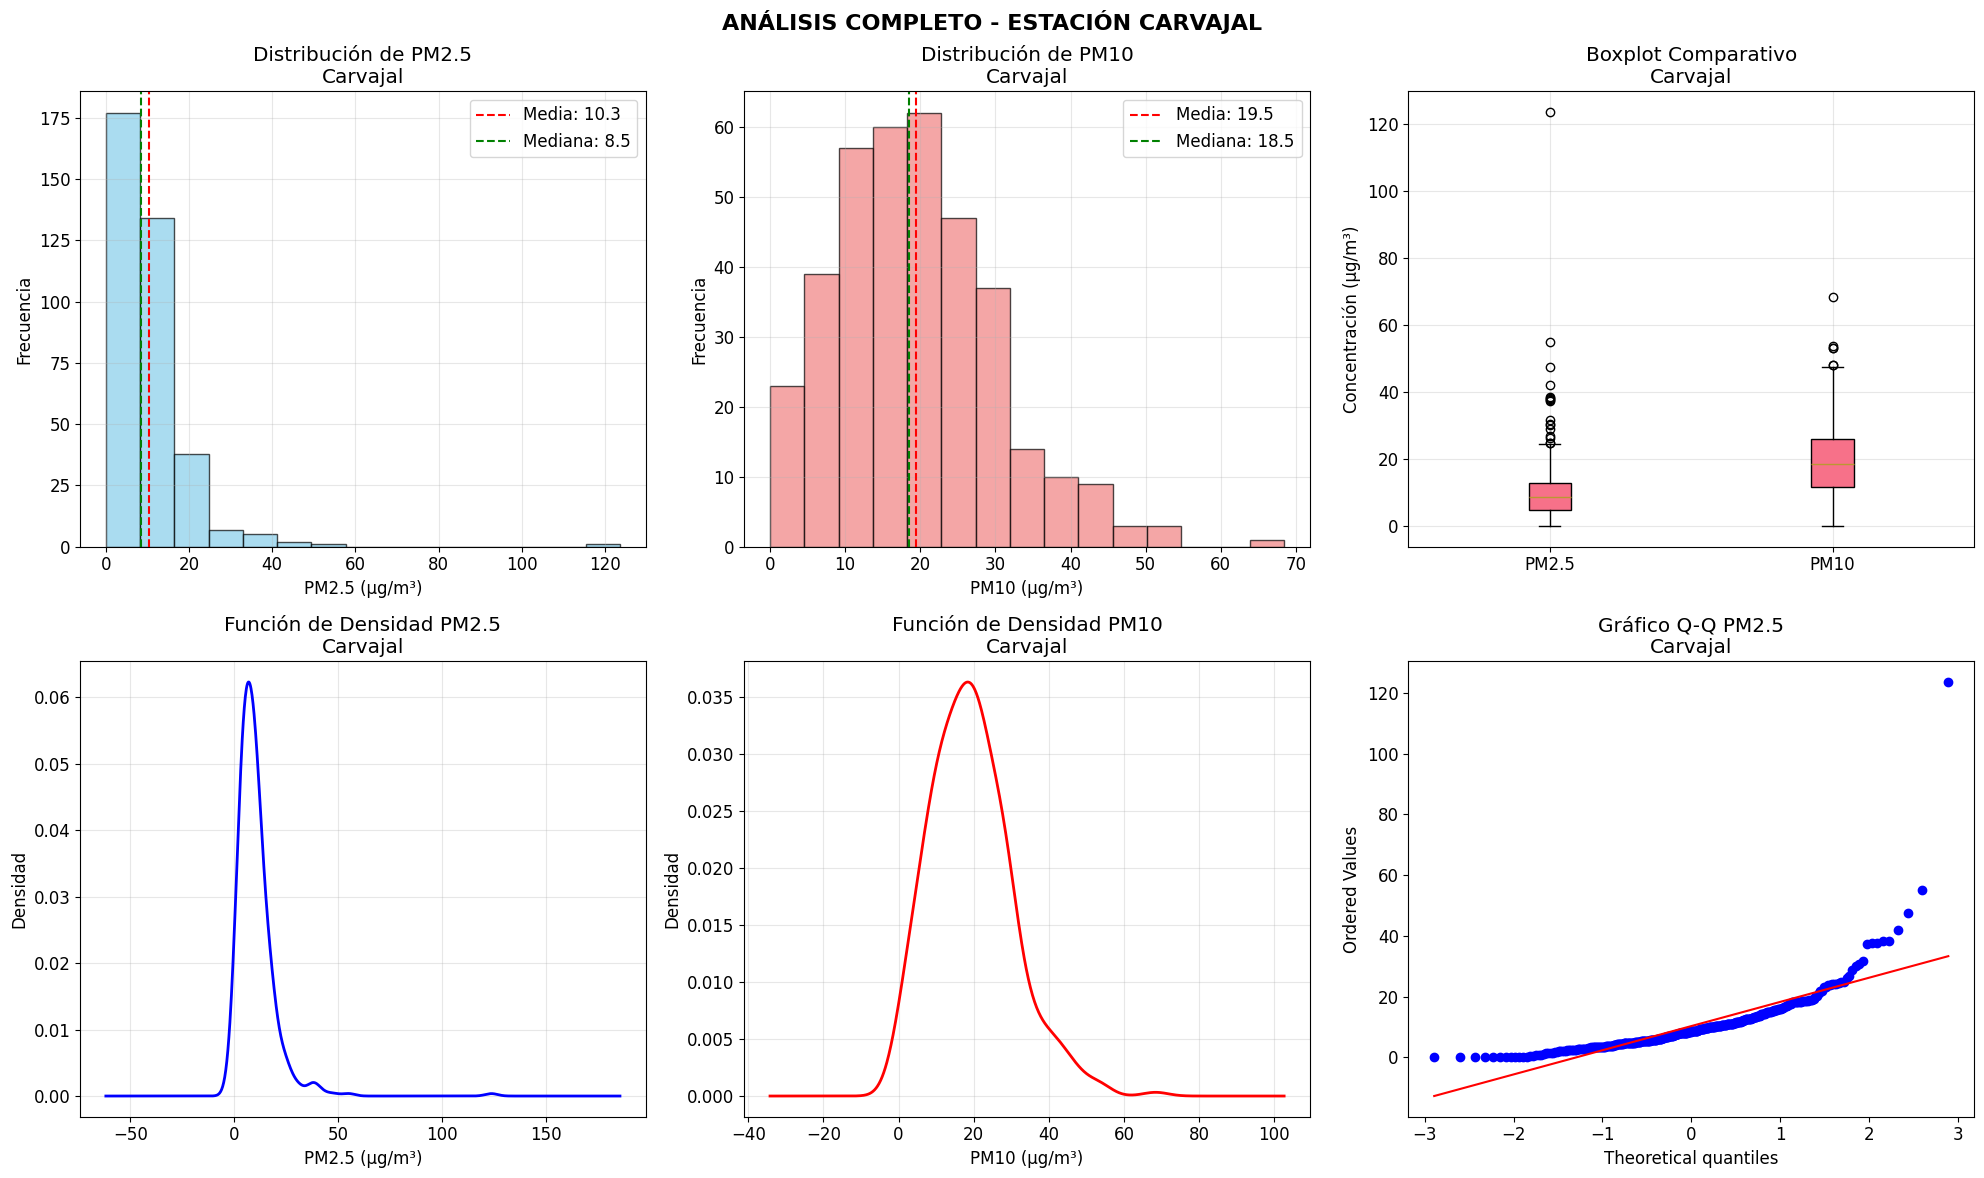

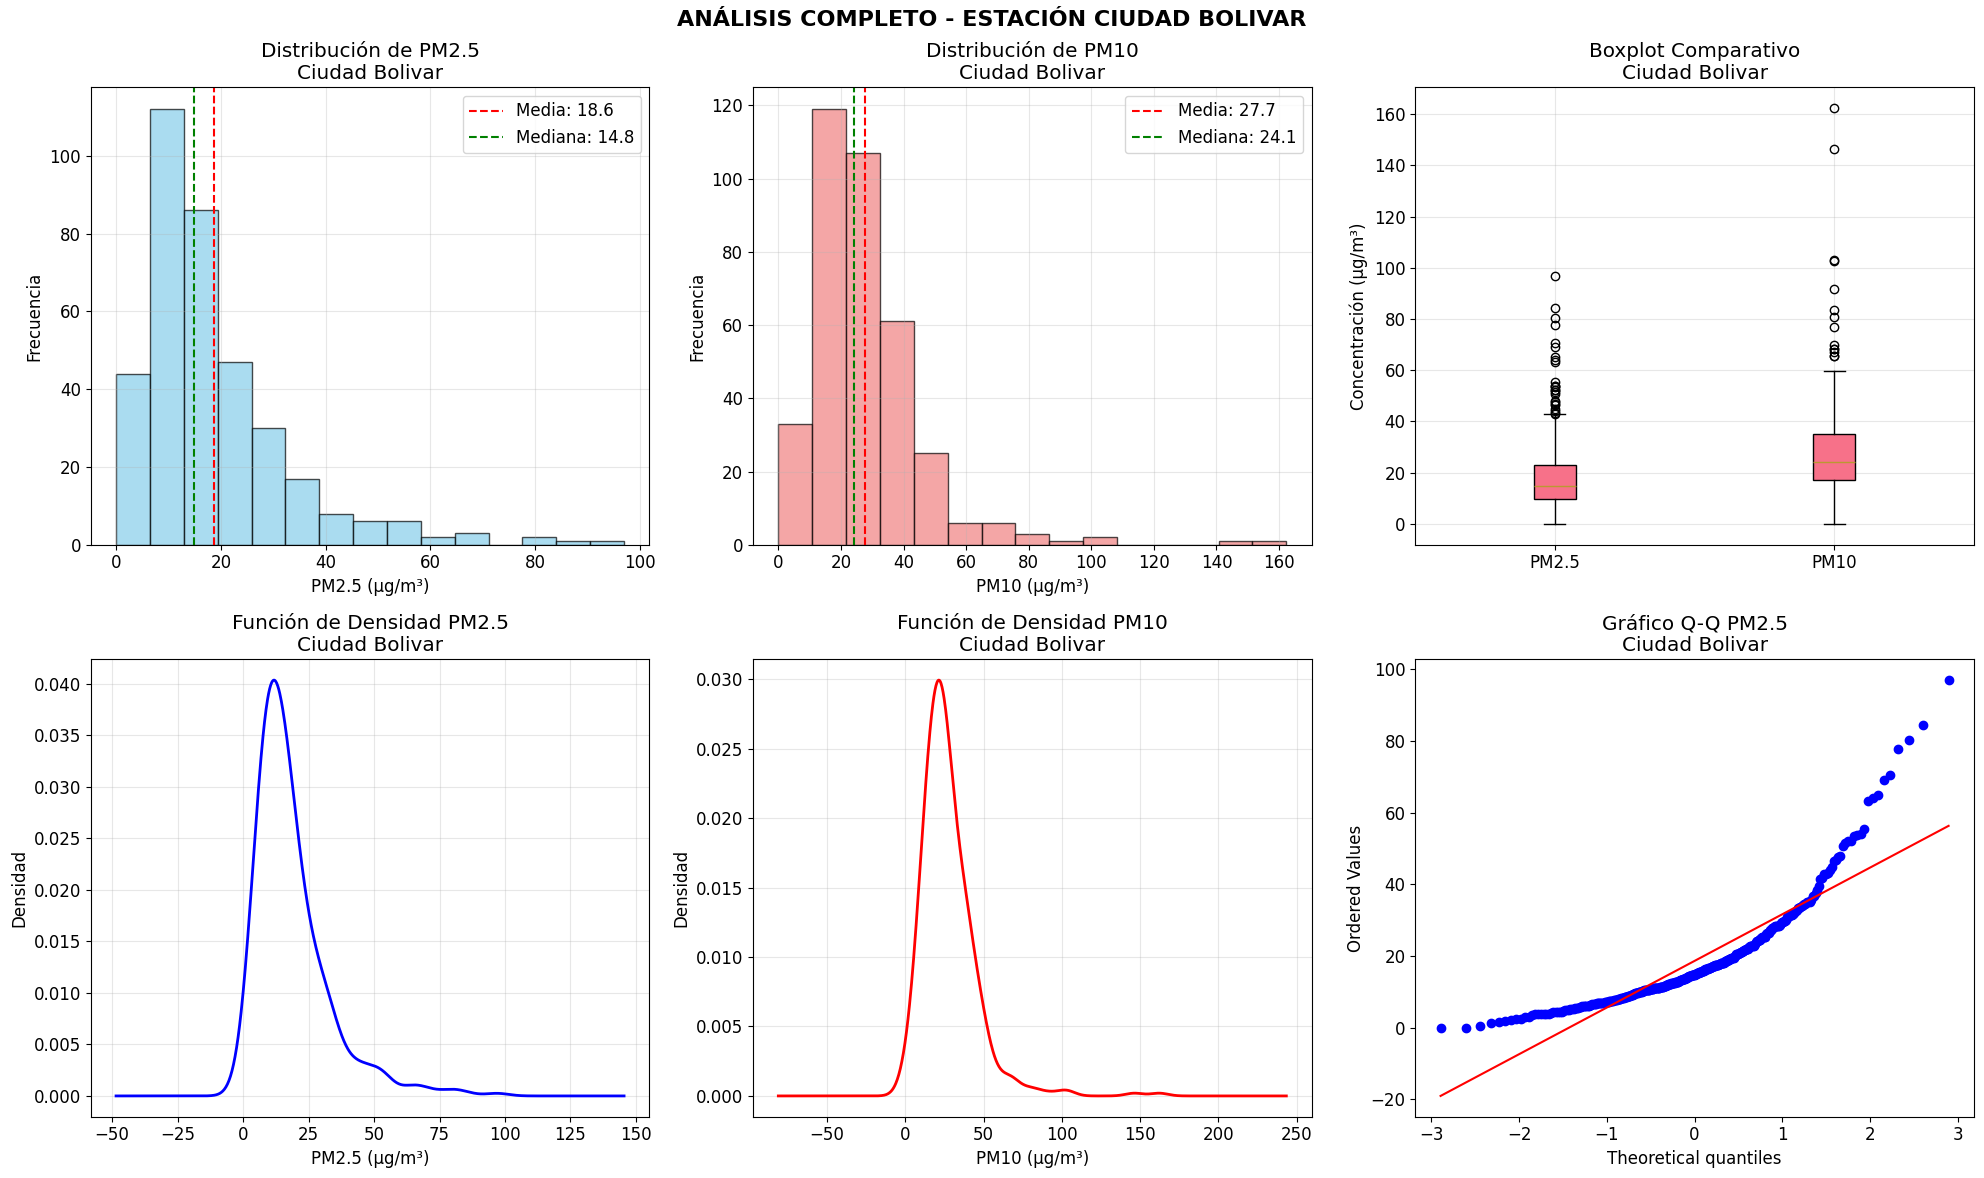

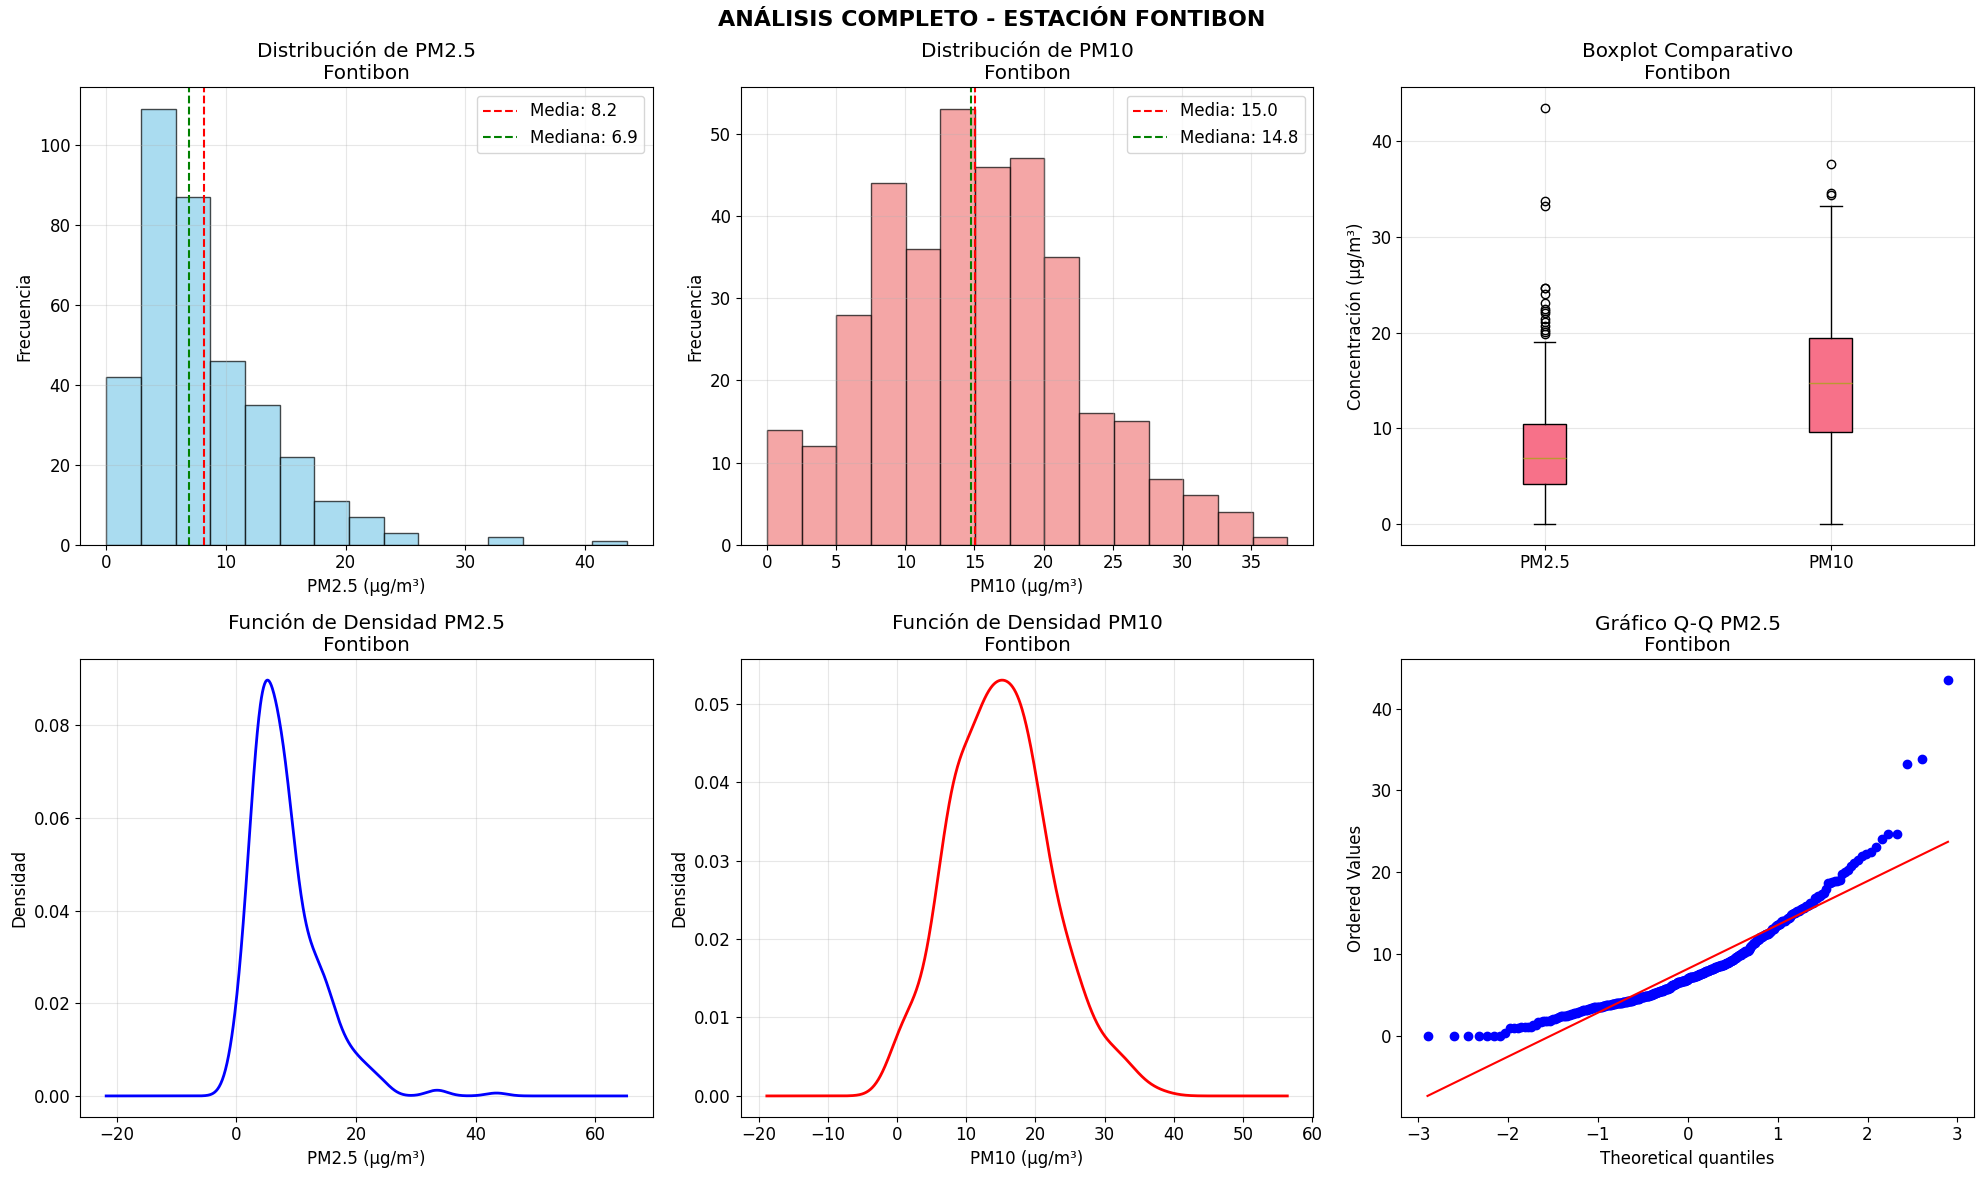

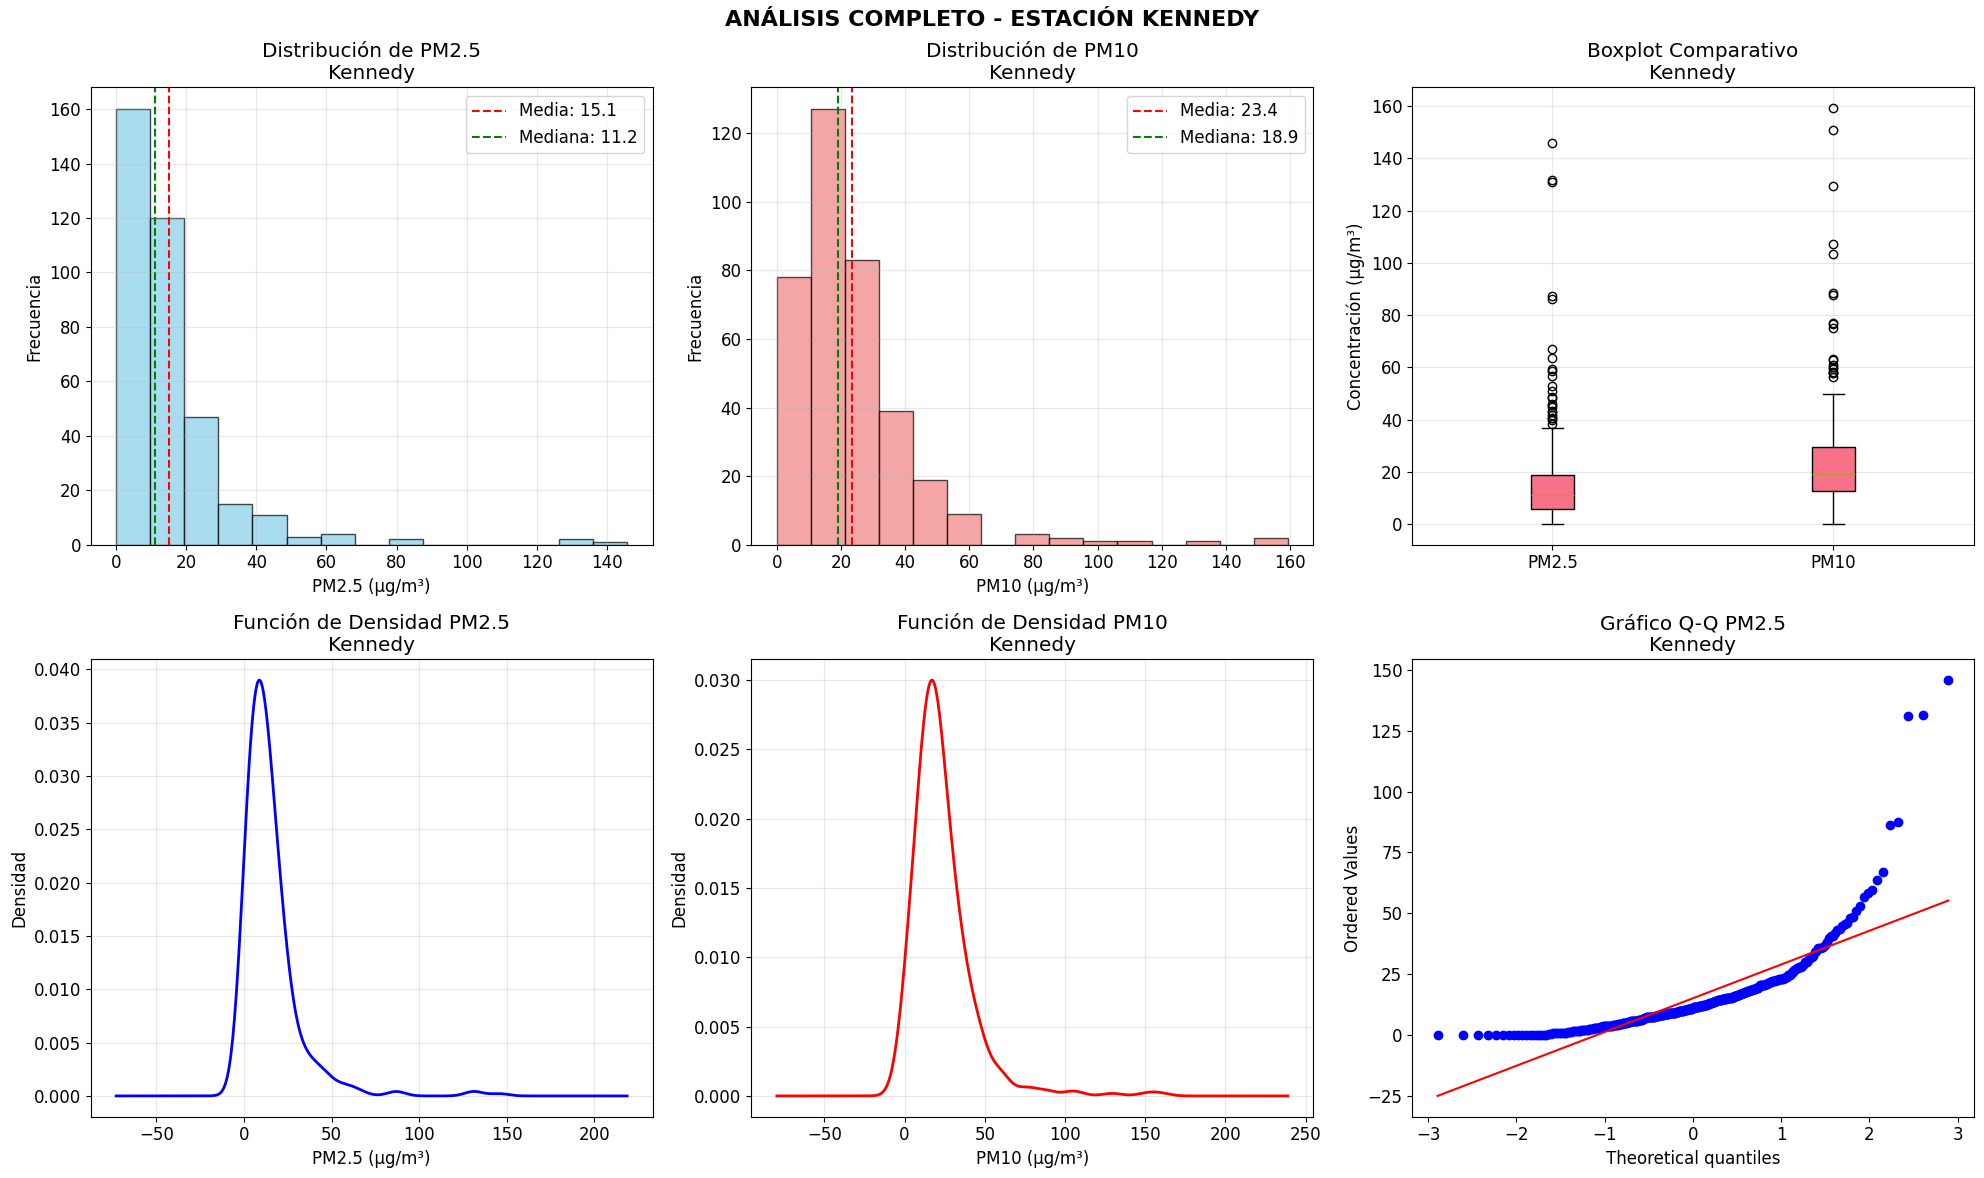

In [6]:
print("\n PASO 6: CREANDO GRÁFICOS DE ANÁLISIS")

def crear_graficos_estacion(estacion, datos_estacion):
    """Crea todos los gráficos para una estación"""

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'ANÁLISIS COMPLETO - ESTACIÓN {estacion.upper()}', fontsize=16, fontweight='bold')

    # 1. Histograma PM2.5
    if 'PM25' in datos_estacion.columns:
        axes[0,0].hist(datos_estacion['PM25'].dropna(), bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].axvline(datos_estacion['PM25'].mean(), color='red', linestyle='--', label=f'Media: {datos_estacion["PM25"].mean():.1f}')
        axes[0,0].axvline(datos_estacion['PM25'].median(), color='green', linestyle='--', label=f'Mediana: {datos_estacion["PM25"].median():.1f}')
        axes[0,0].set_title(f'Distribución de PM2.5\n{estacion}')
        axes[0,0].set_xlabel('PM2.5 (µg/m³)')
        axes[0,0].set_ylabel('Frecuencia')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

    # 2. Histograma PM10
    if 'PM10' in datos_estacion.columns:
        axes[0,1].hist(datos_estacion['PM10'].dropna(), bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,1].axvline(datos_estacion['PM10'].mean(), color='red', linestyle='--', label=f'Media: {datos_estacion["PM10"].mean():.1f}')
        axes[0,1].axvline(datos_estacion['PM10'].median(), color='green', linestyle='--', label=f'Mediana: {datos_estacion["PM10"].median():.1f}')
        axes[0,1].set_title(f'Distribución de PM10\n{estacion}')
        axes[0,1].set_xlabel('PM10 (µg/m³)')
        axes[0,1].set_ylabel('Frecuencia')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

    # 3. Boxplot comparativo
    datos_grafico = []
    etiquetas = []

    if 'PM25' in datos_estacion.columns:
        datos_grafico.append(datos_estacion['PM25'].dropna())
        etiquetas.append('PM2.5')
    if 'PM10' in datos_estacion.columns:
        datos_grafico.append(datos_estacion['PM10'].dropna())
        etiquetas.append('PM10')

    if datos_grafico:
        axes[0,2].boxplot(datos_grafico, labels=etiquetas, patch_artist=True)
        axes[0,2].set_title(f'Boxplot Comparativo\n{estacion}')
        axes[0,2].set_ylabel('Concentración (µg/m³)')
        axes[0,2].grid(True, alpha=0.3)

    # 4. Gráfico de densidad PM2.5
    if 'PM25' in datos_estacion.columns:
        datos_estacion['PM25'].dropna().plot.density(ax=axes[1,0], color='blue', linewidth=2)
        axes[1,0].set_title(f'Función de Densidad PM2.5\n{estacion}')
        axes[1,0].set_xlabel('PM2.5 (µg/m³)')
        axes[1,0].set_ylabel('Densidad')
        axes[1,0].grid(True, alpha=0.3)

    # 5. Gráfico de densidad PM10
    if 'PM10' in datos_estacion.columns:
        datos_estacion['PM10'].dropna().plot.density(ax=axes[1,1], color='red', linewidth=2)
        axes[1,1].set_title(f'Función de Densidad PM10\n{estacion}')
        axes[1,1].set_xlabel('PM10 (µg/m³)')
        axes[1,1].set_ylabel('Densidad')
        axes[1,1].grid(True, alpha=0.3)

    # 6. Gráfico Q-Q para normalidad PM2.5
    if 'PM25' in datos_estacion.columns:
        stats.probplot(datos_estacion['PM25'].dropna(), dist="norm", plot=axes[1,2])
        axes[1,2].set_title(f'Gráfico Q-Q PM2.5\n{estacion}')

    plt.tight_layout()
    plt.show()

# Crear gráficos para cada estación
for estacion in estaciones_objetivo:
    datos_estacion = df[df['Estacion'] == estacion]
    if len(datos_estacion) > 0:
        crear_graficos_estacion(estacion, datos_estacion)

# PASO 7: TABLAS DE CONTINGENCIA Y ANÁLISIS COMPARATIVO

In [7]:
print("\n PASO 7: TABLAS DE CONTINGENCIA Y ANÁLISIS COMPARATIVO")

# Crear categorías según estándares de calidad del aire
def categorizar_calidad_aire_pm25(valor):
    if valor <= 12: return 'Buena'
    elif valor <= 35.4: return 'Moderada'
    elif valor <= 55.4: return 'Regular'
    elif valor <= 150.4: return 'Mala'
    else: return 'Muy Mala'

def categorizar_calidad_aire_pm10(valor):
    if valor <= 54: return 'Buena'
    elif valor <= 154: return 'Moderada'
    elif valor <= 254: return 'Regular'
    elif valor <= 354: return 'Mala'
    else: return 'Muy Mala'

# Aplicar categorización
if 'PM25' in df.columns:
    df['Categoria_PM25'] = df['PM25'].apply(categorizar_calidad_aire_pm25)

if 'PM10' in df.columns:
    df['Categoria_PM10'] = df['PM10'].apply(categorizar_calidad_aire_pm10)

# Tablas de contingencia
print("\n TABLAS DE CONTINGENCIA - CALIDAD DEL AIRE POR ESTACIÓN")

if 'Categoria_PM25' in df.columns and 'Estacion' in df.columns:
    print("\n TABLA DE CONTINGENCIA - PM2.5:")
    tabla_contingencia_pm25 = pd.crosstab(df['Estacion'], df['Categoria_PM25'], margins=True)
    print(tabla_contingencia_pm25)

    print("\n TABLA DE CONTINGENCIA NORMALIZADA - PM2.5 (% por fila):")
    tabla_contingencia_pm25_norm = pd.crosstab(df['Estacion'], df['Categoria_PM25'], normalize='index') * 100
    print(tabla_contingencia_pm25_norm.round(2))

if 'Categoria_PM10' in df.columns and 'Estacion' in df.columns:
    print("\n TABLA DE CONTINGENCIA - PM10:")
    tabla_contingencia_pm10 = pd.crosstab(df['Estacion'], df['Categoria_PM10'], margins=True)
    print(tabla_contingencia_pm10)

    print("\n TABLA DE CONTINGENCIA NORMALIZADA - PM10 (% por fila):")
    tabla_contingencia_pm10_norm = pd.crosstab(df['Estacion'], df['Categoria_PM10'], normalize='index') * 100
    print(tabla_contingencia_pm10_norm.round(2))


 PASO 7: TABLAS DE CONTINGENCIA Y ANÁLISIS COMPARATIVO

 TABLAS DE CONTINGENCIA - CALIDAD DEL AIRE POR ESTACIÓN

 TABLA DE CONTINGENCIA - PM2.5:
Categoria_PM25  Buena  Mala  Moderada  Regular   All
Estacion                                            
Carvajal          263     1        93        8   365
Ciudad Bolivar    139     9       192       25   365
Fontibon          288     0        76        1   365
Kennedy           198    10       138       19   365
All               888    20       499       53  1460

 TABLA DE CONTINGENCIA NORMALIZADA - PM2.5 (% por fila):
Categoria_PM25  Buena  Mala  Moderada  Regular
Estacion                                      
Carvajal        72.05  0.27     25.48     2.19
Ciudad Bolivar  38.08  2.47     52.60     6.85
Fontibon        78.90  0.00     20.82     0.27
Kennedy         54.25  2.74     37.81     5.21

 TABLA DE CONTINGENCIA - PM10:
Categoria_PM10  Buena  Moderada  Regular   All
Estacion                                      
Carvajal         

# PASO 8: GRÁFICOS COMPARATIVOS ENTRE ESTACIONES


 PASO 8: GRÁFICOS COMPARATIVOS ENTRE ESTACIONES


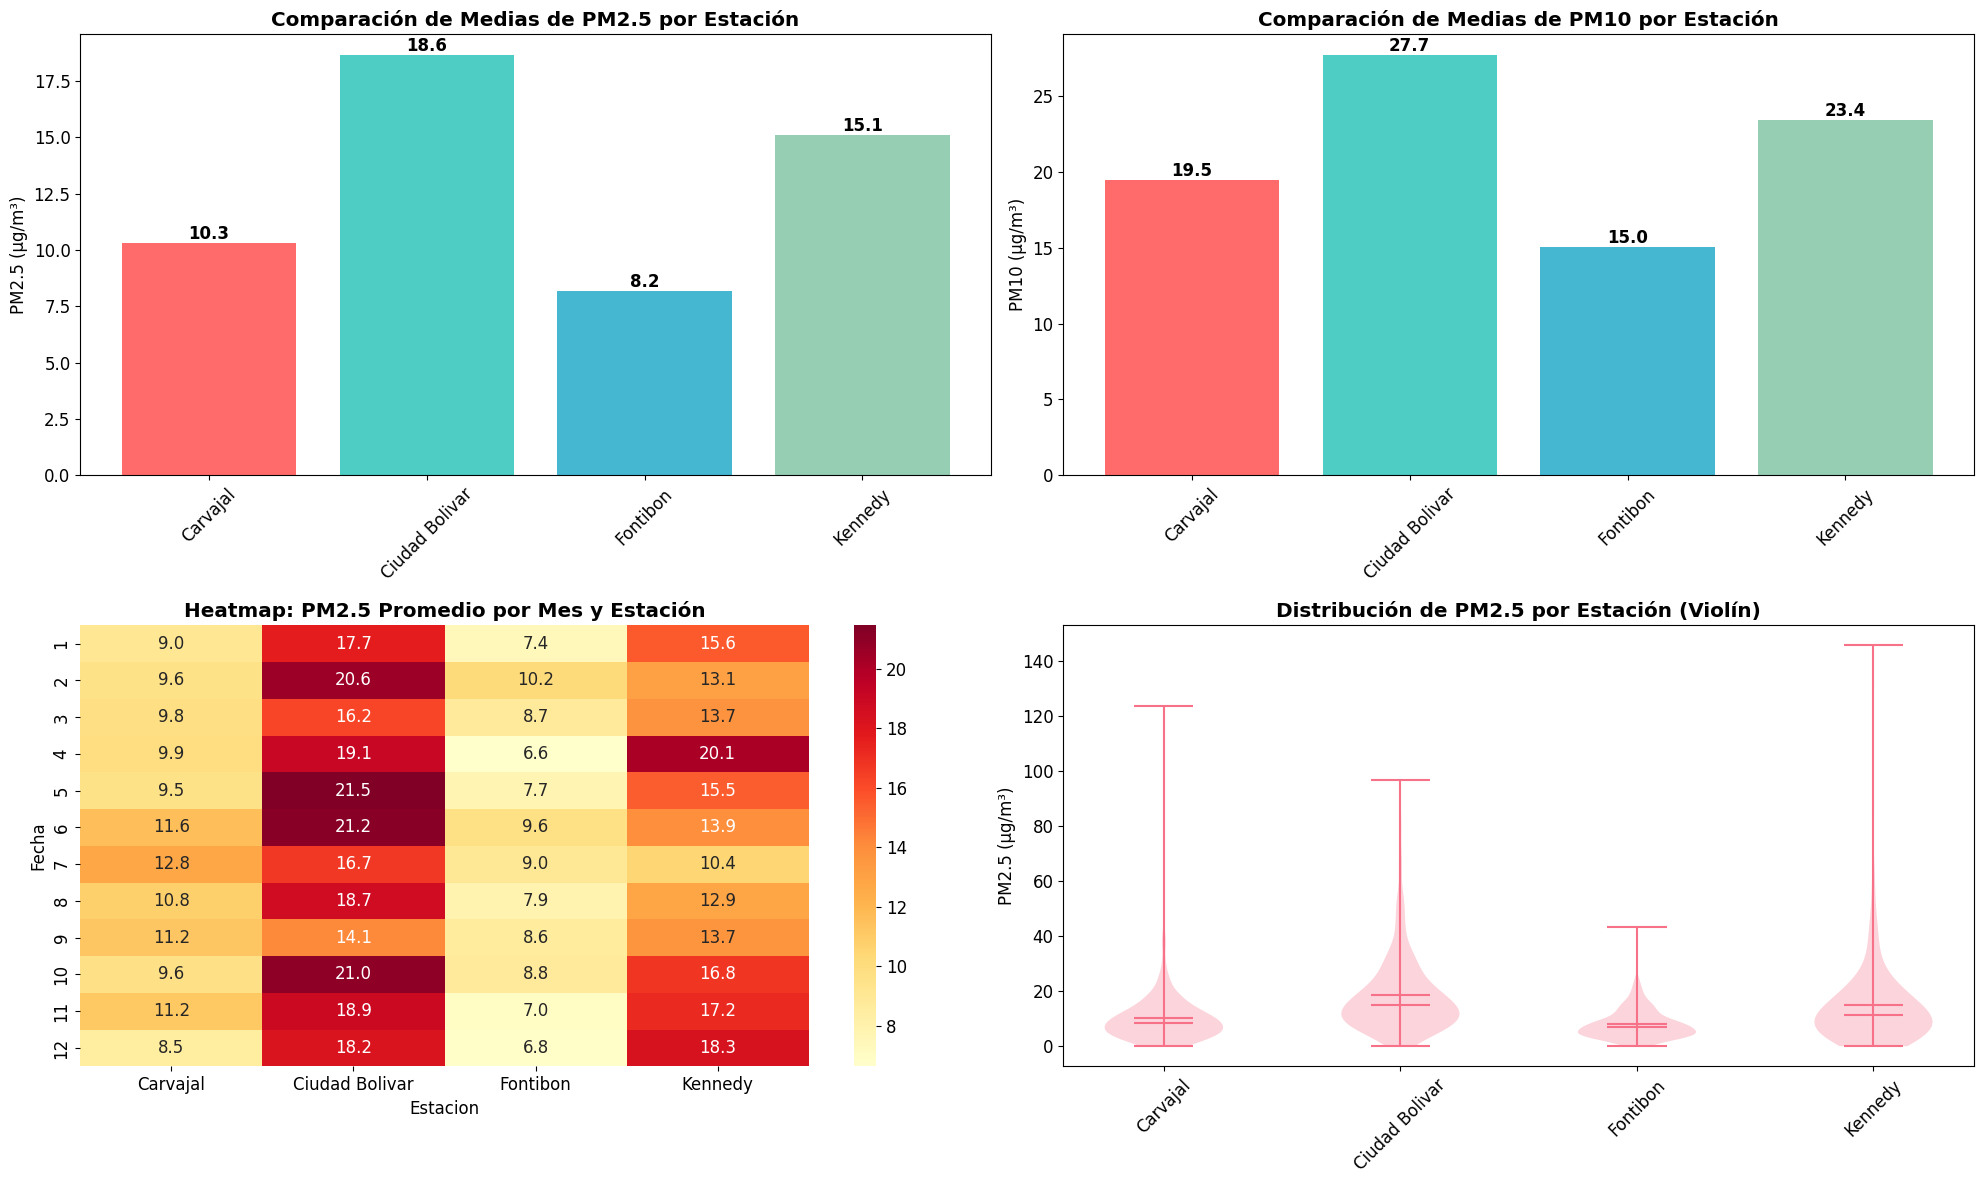

In [8]:
print("\n PASO 8: GRÁFICOS COMPARATIVOS ENTRE ESTACIONES")

# Gráfico comparativo de medias
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Comparación de medias PM2.5
if 'PM25' in df.columns:
    medias_pm25 = df.groupby('Estacion')['PM25'].mean().reindex(estaciones_objetivo)
    barras = axes[0,0].bar(medias_pm25.index, medias_pm25.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[0,0].set_title('Comparación de Medias de PM2.5 por Estación', fontweight='bold')
    axes[0,0].set_ylabel('PM2.5 (µg/m³)')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Agregar valores en las barras
    for bar in barras:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 2. Comparación de medias PM10
if 'PM10' in df.columns:
    medias_pm10 = df.groupby('Estacion')['PM10'].mean().reindex(estaciones_objetivo)
    barras = axes[0,1].bar(medias_pm10.index, medias_pm10.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[0,1].set_title('Comparación de Medias de PM10 por Estación', fontweight='bold')
    axes[0,1].set_ylabel('PM10 (µg/m³)')
    axes[0,1].tick_params(axis='x', rotation=45)

    for bar in barras:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 3. Heatmap de correlación entre estaciones para PM2.5
if 'PM25' in df.columns:
    # Pivot table para heatmap
    pivot_pm25 = df.pivot_table(values='PM25', index=df['Fecha'].dt.month if 'Fecha' in df.columns else None,
                               columns='Estacion', aggfunc='mean').reindex(columns=estaciones_objetivo)

    if not pivot_pm25.empty:
        sns.heatmap(pivot_pm25, annot=True, cmap='YlOrRd', ax=axes[1,0], fmt='.1f')
        axes[1,0].set_title('Heatmap: PM2.5 Promedio por Mes y Estación', fontweight='bold')

# 4. Gráfico de violín comparativo
if 'PM25' in df.columns:
    datos_violin = [df[df['Estacion'] == estacion]['PM25'].dropna() for estacion in estaciones_objetivo]
    axes[1,1].violinplot(datos_violin, showmeans=True, showmedians=True)
    axes[1,1].set_xticks(range(1, len(estaciones_objetivo) + 1))
    axes[1,1].set_xticklabels(estaciones_objetivo, rotation=45)
    axes[1,1].set_title('Distribución de PM2.5 por Estación (Violín)', fontweight='bold')
    axes[1,1].set_ylabel('PM2.5 (µg/m³)')

plt.tight_layout()
plt.show()


# PASO 9: ANÁLISIS TEMPORAL (si hay datos de fecha)


 PASO 9: ANÁLISIS TEMPORAL


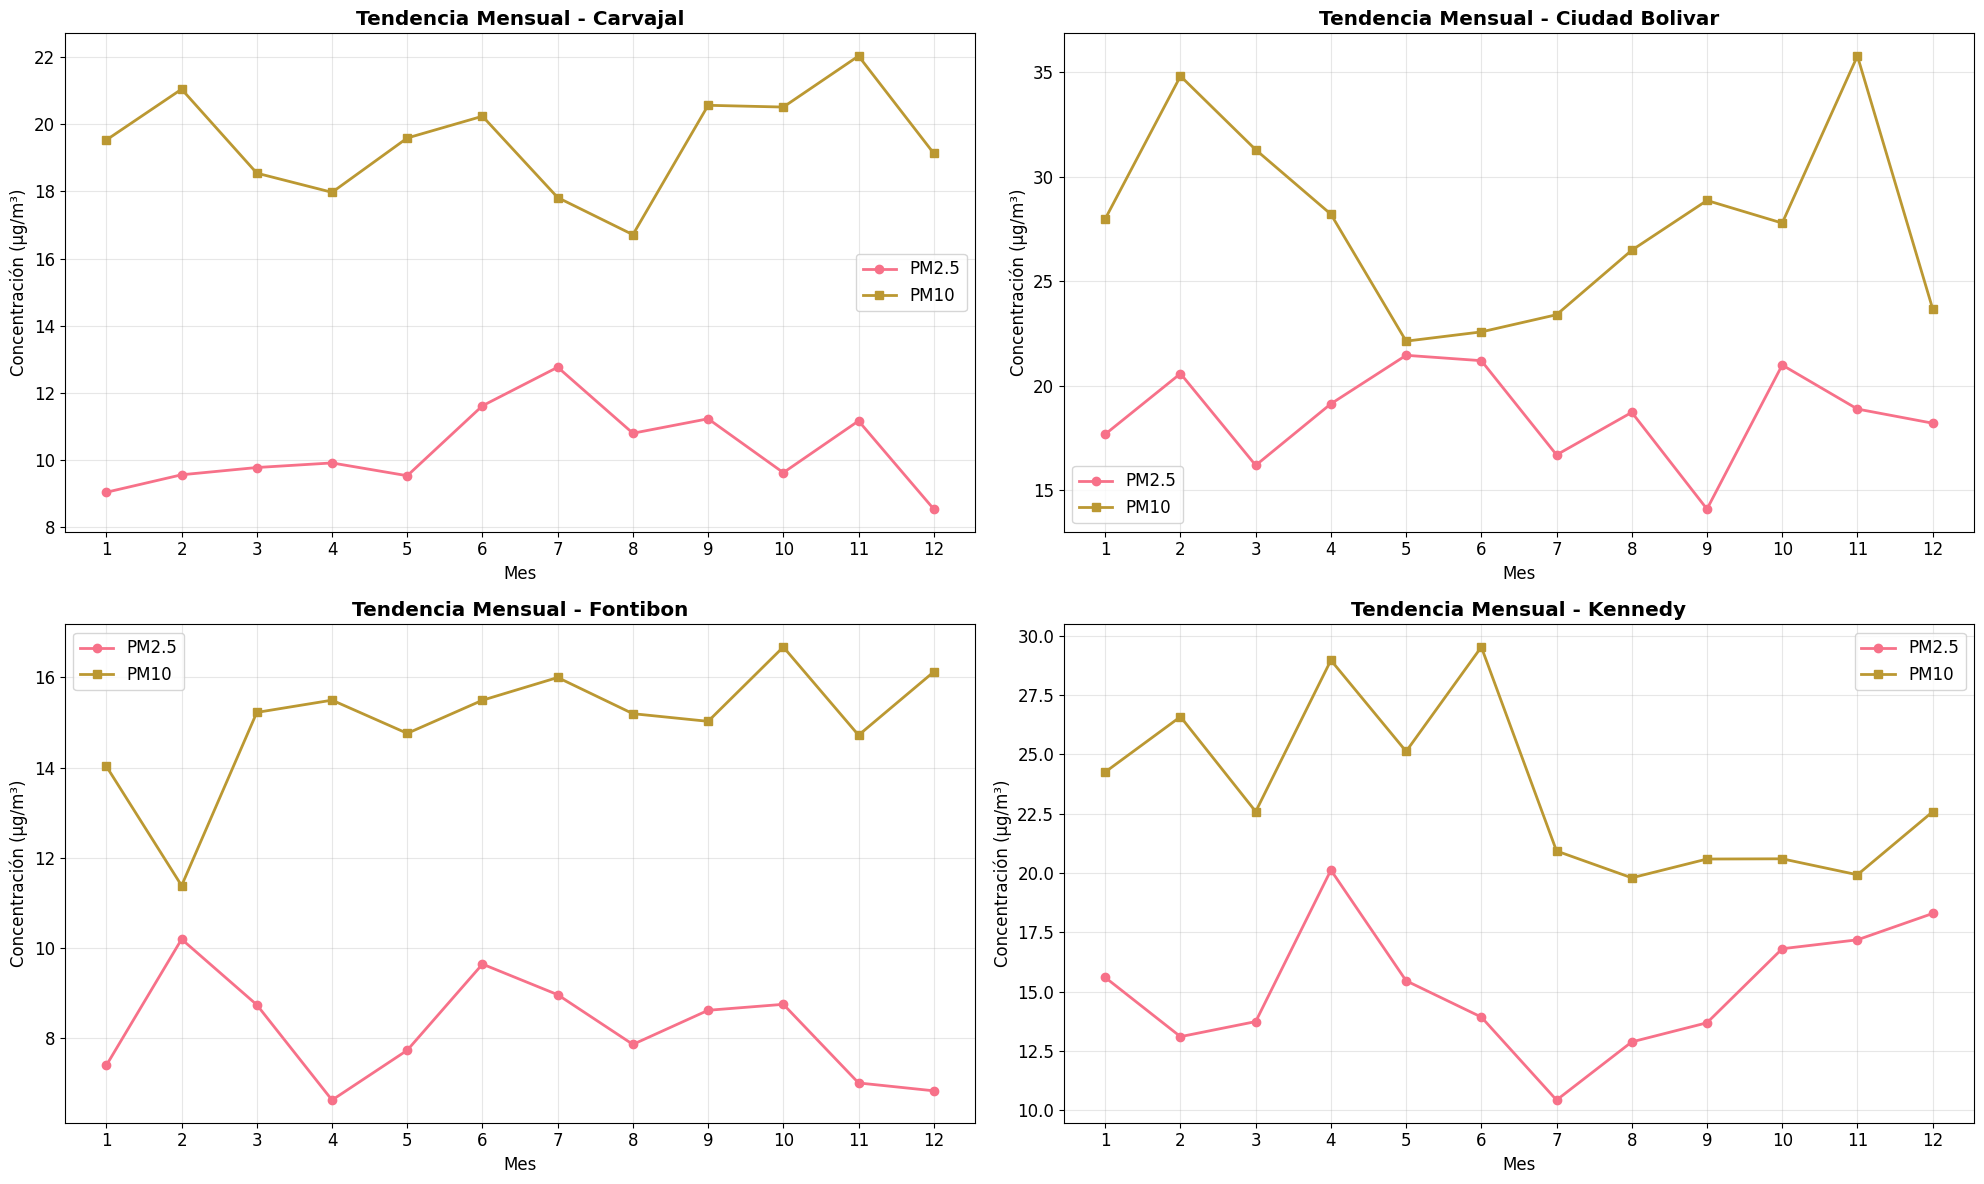

In [9]:
print("\n PASO 9: ANÁLISIS TEMPORAL")

if 'Fecha' in df.columns:
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df['Mes'] = df['Fecha'].dt.month
    df['Dia_Semana'] = df['Fecha'].dt.day_name()

    # Análisis mensual
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    for i, estacion in enumerate(estaciones_objetivo[:4]):  # Máximo 4 subplots
        datos_estacion = df[df['Estacion'] == estacion]

        if 'PM25' in df.columns:
            mensual_pm25 = datos_estacion.groupby('Mes')['PM25'].mean()
            axes[i//2, i%2].plot(mensual_pm25.index, mensual_pm25.values, marker='o', linewidth=2, label='PM2.5')

        if 'PM10' in df.columns:
            mensual_pm10 = datos_estacion.groupby('Mes')['PM10'].mean()
            axes[i//2, i%2].plot(mensual_pm10.index, mensual_pm10.values, marker='s', linewidth=2, label='PM10')

        axes[i//2, i%2].set_title(f'Tendencia Mensual - {estacion}', fontweight='bold')
        axes[i//2, i%2].set_xlabel('Mes')
        axes[i//2, i%2].set_ylabel('Concentración (µg/m³)')
        axes[i//2, i%2].legend()
        axes[i//2, i%2].grid(True, alpha=0.3)
        axes[i//2, i%2].set_xticks(range(1, 13))

    plt.tight_layout()
    plt.show()


# PASO 10: RESUMEN EJECUTIVO PARA OLIMPIADAS STEM

In [10]:
print("\n PASO 10: RESUMEN EJECUTIVO - OLIMPIADAS STEM")
print("="*60)

print("🔬 HALLAZGOS PRINCIPALES:")
print("="*60)

# Resumen comparativo
if 'PM25' in df.columns:
    print("\n COMPARATIVA PM2.5 ENTRE ESTACIONES:")
    resumen_pm25 = df.groupby('Estacion')['PM25'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(resumen_pm25)

if 'PM10' in df.columns:
    print("\n COMPARATIVA PM10 ENTRE ESTACIONES:")
    resumen_pm10 = df.groupby('Estacion')['PM10'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(resumen_pm10)




 PASO 10: RESUMEN EJECUTIVO - OLIMPIADAS STEM
🔬 HALLAZGOS PRINCIPALES:

 COMPARATIVA PM2.5 ENTRE ESTACIONES:
                 mean    std  min     max
Estacion                                 
Carvajal        10.29   9.78  0.0  123.62
Ciudad Bolivar  18.65  14.30  0.0   96.97
Fontibon         8.19   5.71  0.0   43.47
Kennedy         15.11  16.99  0.0  145.77

 COMPARATIVA PM10 ENTRE ESTACIONES:
                 mean    std  min     max
Estacion                                 
Carvajal        19.45  10.95  0.0   68.43
Ciudad Bolivar  27.67  18.11  0.0  162.31
Fontibon        15.04   7.16  0.0   37.60
Kennedy         23.42  19.56  0.0  159.29
